# K-Nearest Neighbors Regression for Flight Fare Prediction

This notebook implements K-Nearest Neighbors (KNN) regression to predict flight base fares. KNN is a non-parametric, instance-based learning algorithm that makes predictions based on the k most similar training examples in the feature space.

**Key Features:**
- Optimal k selection through cross-validation
- Comparison of uniform vs. distance-weighted predictions
- Manhattan distance metric for better performance with mixed features
- Feature scaling for continuous variables
- Comprehensive model evaluation and visualization

**Algorithm Overview:**
KNN predicts by averaging the target values of the k nearest neighbors, making it suitable for capturing local patterns in the data without assuming a global functional form.

## 1. Import Required Libraries

Import essential libraries for:
- **Data manipulation:** pandas, numpy
- **Machine Learning:** scikit-learn (KNeighborsRegressor, StandardScaler)
- **Model evaluation:** metrics (MSE, MAE, R-squared)
- **Visualization:** matplotlib, seaborn
- **Model persistence:** pickle, os

In [21]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


## 2. Load Training and Test Data

Load the preprocessed training and test datasets. The data has already been cleaned and feature-engineered in the preprocessing notebook (`01_Preprocessing.ipynb`), including:
- Log transformation of the target variable (`baseFare`)
- One-hot encoding of categorical features
- Handling of missing values and outliers

In [22]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (125668, 50)
Test data shape: (31418, 50)


## 3. Feature Engineering and Scaling

**Feature Selection and Preprocessing:**
KNN is sensitive to feature scales, so we apply StandardScaler to continuous variables while preserving binary and one-hot encoded features.

**Features to scale:**
- `seatsRemaining` - Number of available seats
- `Booking Lead Time` - Days between booking and departure
- `travelDuration_minutes` - Flight duration
- `departureTime_sin` & `departureTime_cos` Time of the departure

**Unscaled features:**
- `elapsedDays` - Binary indicator (same day vs. next day (overnight))
- `isBasicEconomy` - Binary indicator
- One-hot encoded airports and airlines (already 0/1)

This selective scaling ensures optimal distance calculations in the Manhattan metric space.

In [23]:
target_column = 'baseFare'

features_to_scale = ['seatsRemaining', 'Booking Lead Time', 'travelDuration_minutes', 'departureTime_sin', 'departureTime_cos']

all_feature_columns = train_data.columns.tolist()

if target_column in all_feature_columns:
    all_feature_columns.remove(target_column)

print(f"- Total feature columns: {len(all_feature_columns)}")

airport_features = [col for col in all_feature_columns if col.startswith(('startingAirport_', 'destinationAirport_'))]
airline_features = [col for col in all_feature_columns if col.startswith('segmentsAirlineName_')]
continuous_features = [col for col in all_feature_columns if not col.startswith(('startingAirport_', 'destinationAirport_', 'segmentsAirlineName_', 'isBasicEconomy' , 'elapsedDays'))]
boolean_features = [col for col in all_feature_columns if col.startswith(('isBasicEconomy', 'elapsedDays'))]

continuous_scaled = [col for col in continuous_features if col in features_to_scale]
continuous_unscaled = [col for col in continuous_features if col not in features_to_scale]

feature_columns = continuous_scaled + continuous_unscaled + airport_features + airline_features + boolean_features

X_train = train_data[feature_columns].copy()
y_train = train_data[target_column]

X_test = test_data[feature_columns].copy()
y_test = test_data[target_column] if target_column in test_data.columns else None

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler.fit(X_train[features_to_scale])

X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

X_train_final = X_train_scaled.values
X_test_final = X_test_scaled.values

- Total feature columns: 49


## 4. Find Optimal k with Cross-Validation

**Hyperparameter Optimization:**
Determine the optimal number of neighbors (k) using 5-fold cross-validation on the training set.

**Search Strategy:**
- Test k values from 1 to 20
- Evaluate using MSE (Mean Squared Error)
- Use uniform weights during optimization
- Apply Manhattan distance metric (L1 norm)

In [24]:
k_values = range(1, 21)
cv_mse_scores = []

X_train_subset = X_train_final
y_train_subset = y_train

for k in tqdm(k_values, desc="Testing k values", unit="k"):
    knn_temp = KNeighborsRegressor(
        n_neighbors=k,
        weights='uniform',
        metric='manhattan'
    )
    
    cv_scores_mse = cross_val_score(knn_temp, X_train_subset, y_train_subset, 
                                    cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_mse_scores.append(-cv_scores_mse.mean())

optimal_k = k_values[np.argmin(cv_mse_scores)]
optimal_mse = min(cv_mse_scores)

Testing k values: 100%|██████████| 20/20 [18:22<00:00, 55.14s/k]


## 5. Train KNN Model without Neighbor Weighting (Uniform)

**Model Configuration: Uniform Weights**

Train the first KNN model where all k nearest neighbors contribute equally to predictions.

**Characteristics:**
- **Weights:** `uniform` - Each neighbor has equal influence
- **Distance Metric:** Manhattan (L1)
- **Use Case:** Works well when neighbors are roughly equidistant or when all nearby points should be considered equally

This approach is simpler and can be more robust when the optimal k is well-chosen, as it avoids potential issues with very small distances causing excessive weight concentration.

In [25]:
knn_uniform = KNeighborsRegressor(
    n_neighbors=optimal_k,
    weights='uniform', 
    algorithm='auto',       
    metric='manhattan',     
    p=1                    
)

knn_uniform.fit(X_train_final, y_train)

print(f"Model comparison distance based")
print(f"- k: {optimal_k}")
print(f"- Distance metric: Manhattan")
print(f"- Weights: uniform")
print(f"- Training samples: {X_train_final.shape[0]}")
print(f"- Features: {X_train_final.shape[1]}")

Model comparison distance based
- k: 10
- Distance metric: Manhattan
- Weights: uniform
- Training samples: 125668
- Features: 49


## 6. Train KNN Model with Distance-Based Weighting

Train the second model using distance-based weights, where closer neighbors have more influence on the prediction.

In [26]:
knn_distance = KNeighborsRegressor(
    n_neighbors=optimal_k,
    weights='distance',
    algorithm='auto',       
    metric='manhattan',     
    p=1                    
)

knn_distance.fit(X_train_final, y_train)
print(f"Model comparison distance based")
print(f"- k: {optimal_k}")
print(f"- Distance metric: Manhattan")
print(f"- Weights: distance")
print(f"- Training samples: {X_train_final.shape[0]}")
print(f"- Features: {X_train_final.shape[1]}")

Model comparison distance based
- k: 10
- Distance metric: Manhattan
- Weights: distance
- Training samples: 125668
- Features: 49


## 7. Cross-Validation Results Visualization

Visualize the cross-validation results to understand the k optimization process.

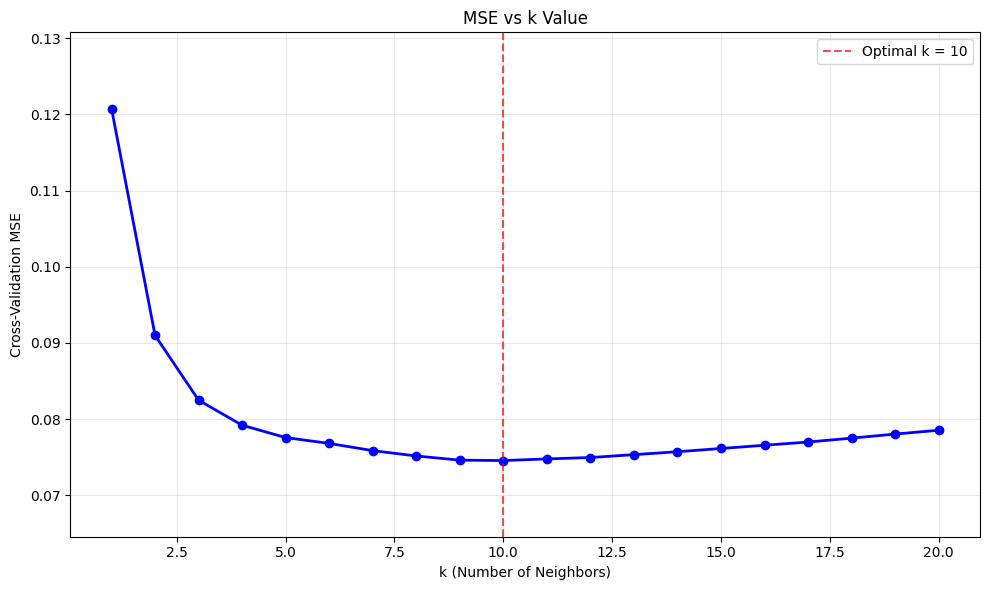

Selected k = 10 with MSE = 0.0746
Cross-validation performance range:
  MSE range: 0.0462 (from 0.0746 to 0.1208)


In [27]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, cv_mse_scores, 'b-o', linewidth=2, markersize=6)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal k = {optimal_k}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation MSE')
plt.title('MSE vs k Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim([min(cv_mse_scores) - 0.01, max(cv_mse_scores) + 0.01])

plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'k': k_values,
    'CV_MSE': cv_mse_scores
})

results_df_sorted = results_df.sort_values('CV_MSE', ascending=True)

print(f"Selected k = {optimal_k} with MSE = {optimal_mse:.4f}")

mse_range = max(cv_mse_scores) - min(cv_mse_scores)
print(f"Cross-validation performance range:")
print(f"  MSE range: {mse_range:.4f} (from {min(cv_mse_scores):.4f} to {max(cv_mse_scores):.4f})")

## 8. Model Predictions on Test Set

**Generate Predictions:**
Apply both trained models (uniform and distance-weighted) to the test set.

**Log Transformation Reversal:**
Since the target variable was log-transformed during preprocessing (`np.log1p`), we apply the inverse transformation (`np.expm1()`) to convert predictions back to the original dollar scale. This ensures all evaluation metrics are interpretable in dollars.

**Comparison Focus:**
- Prediction ranges and distributions in original dollar values
- Performance differences between weighting schemes
- Model behavior on unseen data

In [28]:
y_pred_uniform_log = knn_uniform.predict(X_test_final)
y_pred_uniform = np.expm1(y_pred_uniform_log) 

y_pred_distance_log = knn_distance.predict(X_test_final)
y_pred_distance = np.expm1(y_pred_distance_log) 

y_test_original = np.expm1(y_test)

## 9. Evaluate and Compare Model Performance

Calculate and compare evaluation metrics for both KNN models (uniform vs distance-weighted).

Metric                         Uniform Weights      Distance Weights    
Mean Squared Error (MSE)       4326.56              4159.87             
Root Mean Squared Error (RMSE) $65.78               $64.50              
Mean Absolute Error (MAE)      $34.38               $33.19              
R-squared Score                0.6849               0.6970              


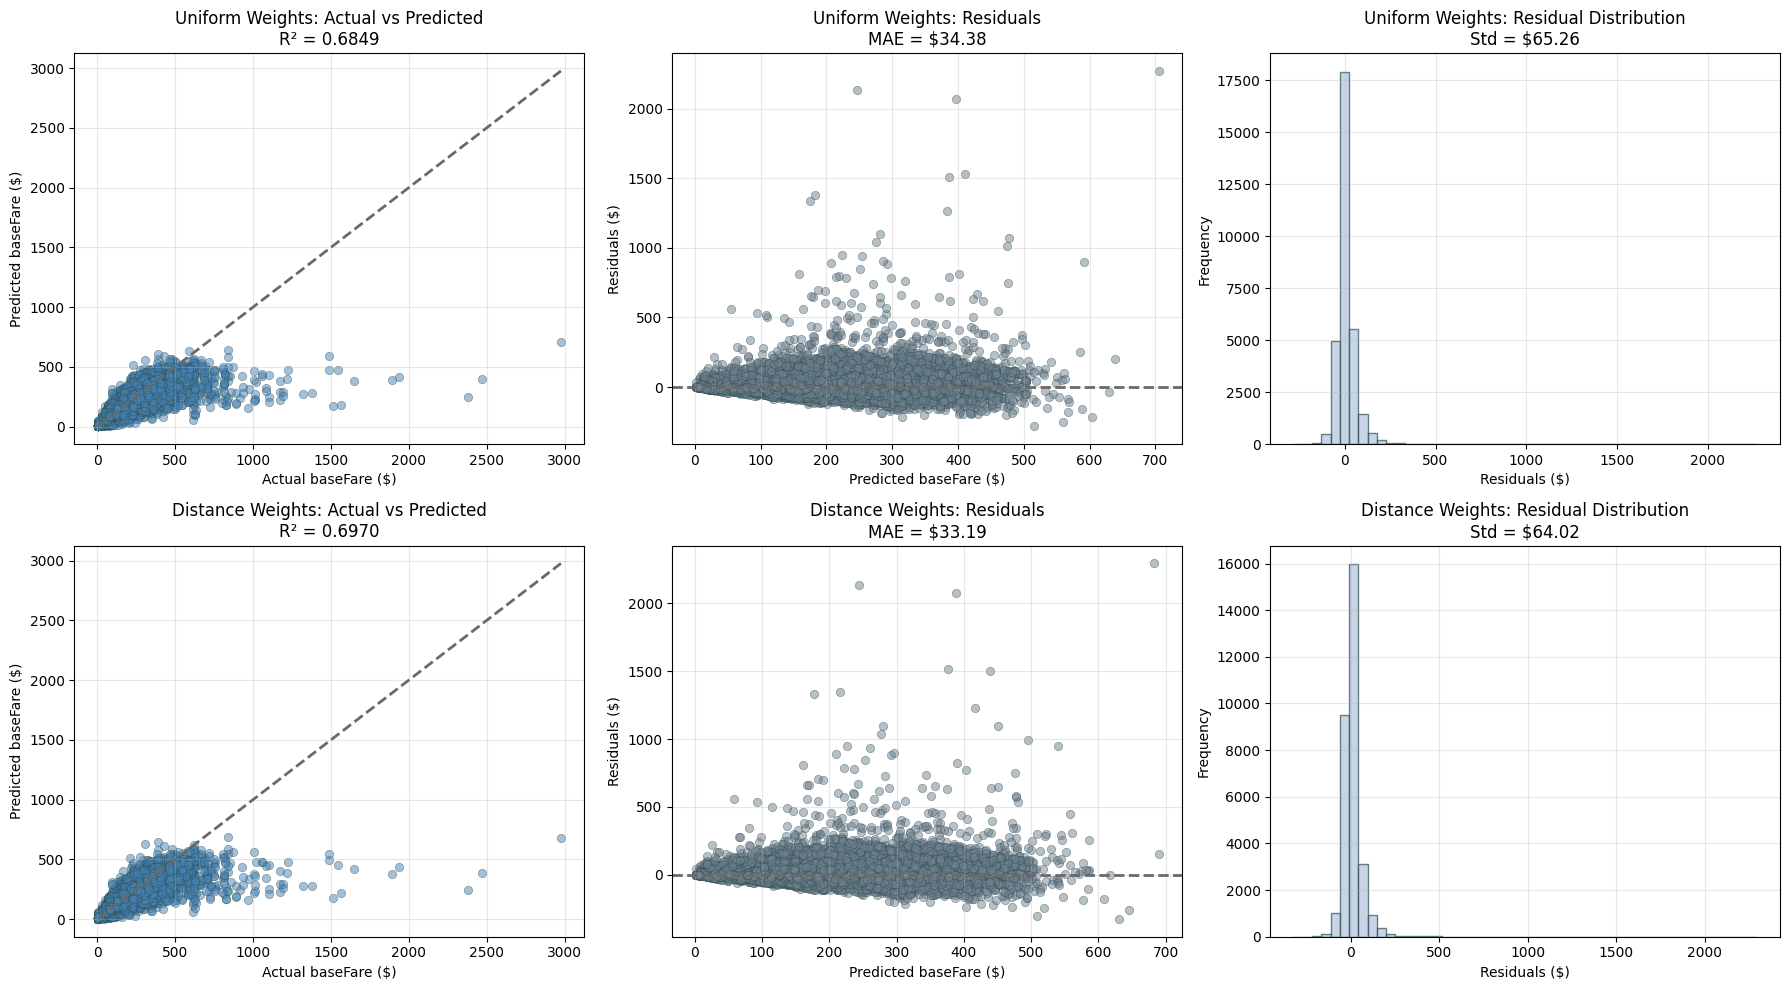

In [29]:
mse_uniform = mean_squared_error(y_test_original, y_pred_uniform)
rmse_uniform = np.sqrt(mse_uniform)
mae_uniform = mean_absolute_error(y_test_original, y_pred_uniform)
r2_uniform = r2_score(y_test_original, y_pred_uniform)

mse_distance = mean_squared_error(y_test_original, y_pred_distance)
rmse_distance = np.sqrt(mse_distance)
mae_distance = mean_absolute_error(y_test_original, y_pred_distance)
r2_distance = r2_score(y_test_original, y_pred_distance)

print(f"{'Metric':<30} {'Uniform Weights':<20} {'Distance Weights':<20}")
print(f"{'Mean Squared Error (MSE)':<30} {mse_uniform:<20.2f} {mse_distance:<20.2f}")
print(f"{'Root Mean Squared Error (RMSE)':<30} ${rmse_uniform:<19.2f} ${rmse_distance:<19.2f}")
print(f"{'Mean Absolute Error (MAE)':<30} ${mae_uniform:<19.2f} ${mae_distance:<19.2f}")
print(f"{'R-squared Score':<30} {r2_uniform:<20.4f} {r2_distance:<20.4f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].scatter(y_test_original, y_pred_uniform, alpha=0.5, color='steelblue', edgecolors='darkslategray', linewidth=0.5)
axes[0, 0].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--', color='dimgray', lw=2)
axes[0, 0].set_xlabel('Actual baseFare ($)')
axes[0, 0].set_ylabel('Predicted baseFare ($)')
axes[0, 0].set_title(f'Uniform Weights: Actual vs Predicted\nR² = {r2_uniform:.4f}')
axes[0, 0].grid(True, alpha=0.3)

residuals_uniform = y_test_original - y_pred_uniform
axes[0, 1].scatter(y_pred_uniform, residuals_uniform, alpha=0.5, color='slategray', edgecolors='darkslategray', linewidth=0.5)
axes[0, 1].axhline(y=0, color='dimgray', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted baseFare ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title(f'Uniform Weights: Residuals\nMAE = ${mae_uniform:.2f}')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(residuals_uniform, bins=50, alpha=0.7, edgecolor='darkslategray', color='lightsteelblue')
axes[0, 2].set_xlabel('Residuals ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title(f'Uniform Weights: Residual Distribution\nStd = ${residuals_uniform.std():.2f}')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_test_original, y_pred_distance, alpha=0.5, color='steelblue', edgecolors='darkslategray', linewidth=0.5)
axes[1, 0].plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--', color='dimgray', lw=2)
axes[1, 0].set_xlabel('Actual baseFare ($)')
axes[1, 0].set_ylabel('Predicted baseFare ($)')
axes[1, 0].set_title(f'Distance Weights: Actual vs Predicted\nR² = {r2_distance:.4f}')
axes[1, 0].grid(True, alpha=0.3)

residuals_distance = y_test_original - y_pred_distance
axes[1, 1].scatter(y_pred_distance, residuals_distance, alpha=0.5, color='slategray', edgecolors='darkslategray', linewidth=0.5)
axes[1, 1].axhline(y=0, color='dimgray', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted baseFare ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title(f'Distance Weights: Residuals\nMAE = ${mae_distance:.2f}')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(residuals_distance, bins=50, alpha=0.7, edgecolor='darkslategray', color='lightsteelblue')
axes[1, 2].set_xlabel('Residuals ($)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title(f'Distance Weights: Residual Distribution\nStd = ${residuals_distance.std():.2f}')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Error Analysis

Detailed analysis of prediction errors to understand model strengths and weaknesses.

### Calculate Prediction Errors

Compute absolute and relative errors for detailed analysis of both models.

In [30]:
errors_uniform = y_pred_uniform - y_test_original
abs_errors_uniform = np.abs(errors_uniform)
relative_errors_uniform = (abs_errors_uniform / y_test_original) * 100

error_df_uniform = pd.DataFrame({
    'actual': y_test_original,
    'predicted': y_pred_uniform,
    'error': errors_uniform,
    'abs_error': abs_errors_uniform,
    'relative_error_pct': relative_errors_uniform
})

errors_distance = y_pred_distance - y_test_original
abs_errors_distance = np.abs(errors_distance)
relative_errors_distance = (abs_errors_distance / y_test_original) * 100

error_df_distance = pd.DataFrame({
    'actual': y_test_original,
    'predicted': y_pred_distance,
    'error': errors_distance,
    'abs_error': abs_errors_distance,
    'relative_error_pct': relative_errors_distance
})

### Prediction Range Check

Verify that predictions and actuals are correctly transformed from log scale.

In [31]:
print(f"Actual fares (USD):")
print(f"Min: ${y_test_original.min():.2f}")
print(f"Max: ${y_test_original.max():.2f}")
print(f"Mean: ${y_test_original.mean():.2f}")
print(f"Median: ${y_test_original.median():.2f}")

print(f"\nPredicted fares - Uniform Weights (USD):")
print(f"Min: ${y_pred_uniform.min():.2f}")
print(f"Max: ${y_pred_uniform.max():.2f}")
print(f"Mean: ${y_pred_uniform.mean():.2f}")
print(f"Median: ${np.median(y_pred_uniform):.2f}")

print(f"\nPredicted fares - Distance Weights (USD):")
print(f"Min: ${y_pred_distance.min():.2f}")
print(f"Max: ${y_pred_distance.max():.2f}")
print(f"Mean: ${y_pred_distance.mean():.2f}")
print(f"Median: ${np.median(y_pred_distance):.2f}")

Actual fares (USD):
Min: $1.00
Max: $2976.74
Mean: $193.01
Median: $169.30

Predicted fares - Uniform Weights (USD):
Min: $1.00
Max: $705.23
Mean: $184.75
Median: $168.65

Predicted fares - Distance Weights (USD):
Min: $1.00
Max: $690.08
Mean: $185.21
Median: $168.51


### Analysis by Fare Range

Investigate how model performance varies across different price ranges.

In [32]:
bins = [0, 100, 200, 300, 500, 1000, 3000]
labels = ['0-100 USD', '100-200 USD', '200-300 USD', '300-500 USD', '500-1000 USD', '1000+ USD']

error_df_uniform['fare_range'] = pd.cut(error_df_uniform['actual'], bins=bins, labels=labels)
error_df_distance['fare_range'] = pd.cut(error_df_distance['actual'], bins=bins, labels=labels)

range_analysis_uniform = error_df_uniform.groupby('fare_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'std'],
    'relative_error_pct': ['mean', 'median'],
    'actual': 'count'
}).round(2)

range_analysis_uniform.columns = ['MAE', 'Median_AE', 'Std_AE', 'Mean_Rel_%', 'Median_Rel_%', 'Count']

range_analysis_distance = error_df_distance.groupby('fare_range', observed=True).agg({
    'abs_error': ['mean', 'median', 'std'],
    'relative_error_pct': ['mean', 'median'],
    'actual': 'count'
}).round(2)

range_analysis_distance.columns = ['MAE', 'Median_AE', 'Std_AE', 'Mean_Rel_%', 'Median_Rel_%', 'Count']

print("Performance by Fare Range - Uniform Weights:")
print(range_analysis_uniform)
print("\nPerformance by Fare Range - Distance Weights:")
print(range_analysis_distance)

Performance by Fare Range - Uniform Weights:
                  MAE  Median_AE  Std_AE  Mean_Rel_%  Median_Rel_%  Count
fare_range                                                               
0-100 USD       18.72      13.67   18.31       35.88         22.27   5920
100-200 USD     22.75      16.80   21.73       15.61         11.68  13162
200-300 USD     35.73      28.95   29.90       14.80         12.09   7230
300-500 USD     60.72      45.73   55.46       16.35         13.18   4642
500-1000 USD   220.85     181.79  144.03       35.01         32.72    430
1000+ USD     1023.44     888.38  436.17       73.31         76.18     34

Performance by Fare Range - Distance Weights:
                  MAE  Median_AE  Std_AE  Mean_Rel_%  Median_Rel_%  Count
fare_range                                                               
0-100 USD       17.27      11.91   17.91       32.53         19.31   5920
100-200 USD     21.98      15.86   21.75       15.05         10.99  13162
200-300 USD     35.1

### Visualization of Performance by Fare Range

Compare model performance across different price ranges.

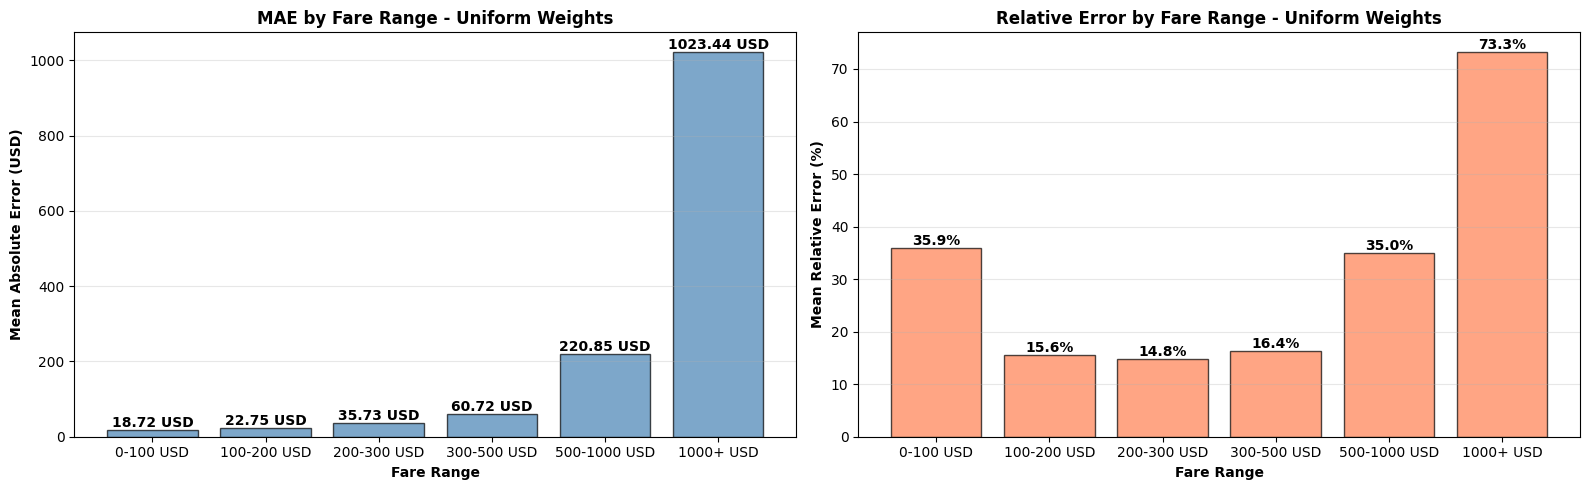

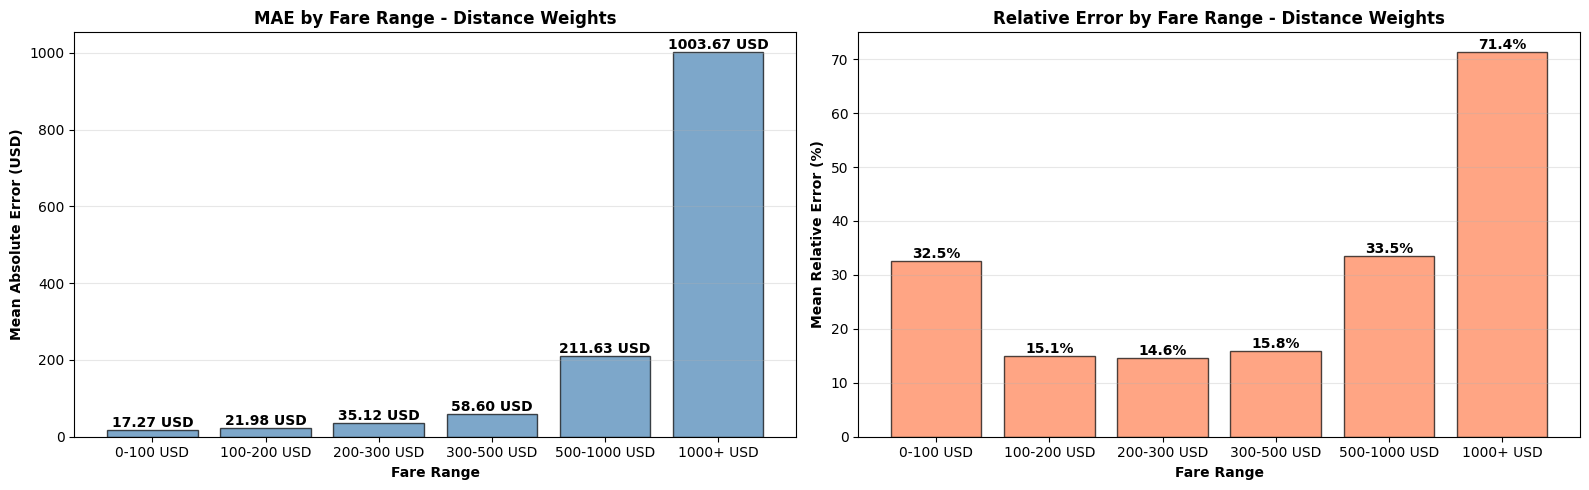

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(len(range_analysis_uniform)), range_analysis_uniform['MAE'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(range_analysis_uniform)))
axes[0].set_xticklabels(range_analysis_uniform.index, rotation=0)
axes[0].set_ylabel('Mean Absolute Error (USD)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range - Uniform Weights', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis_uniform['MAE']):
    axes[0].text(i, v, f'{v:.2f} USD', ha='center', va='bottom', fontweight='bold')

axes[1].bar(range(len(range_analysis_uniform)), range_analysis_uniform['Mean_Rel_%'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(range_analysis_uniform)))
axes[1].set_xticklabels(range_analysis_uniform.index, rotation=0)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range - Uniform Weights', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis_uniform['Mean_Rel_%']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(range(len(range_analysis_distance)), range_analysis_distance['MAE'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(range_analysis_distance)))
axes[0].set_xticklabels(range_analysis_distance.index, rotation=0)
axes[0].set_ylabel('Mean Absolute Error (USD)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range - Distance Weights', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis_distance['MAE']):
    axes[0].text(i, v, f'{v:.2f} USD', ha='center', va='bottom', fontweight='bold')

axes[1].bar(range(len(range_analysis_distance)), range_analysis_distance['Mean_Rel_%'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(range_analysis_distance)))
axes[1].set_xticklabels(range_analysis_distance.index, rotation=0)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range - Distance Weights', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(range_analysis_distance['Mean_Rel_%']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Worst Predictions Analysis

Identify and analyze the cases where the model performs worst. Top 10 worst results here.

In [34]:
worst_10_uniform = error_df_uniform.nlargest(10, 'abs_error')[['error', 'actual', 'predicted']]
print(worst_10_uniform)

             error   actual   predicted
26233 -2271.505314  2976.74  705.234686
17750 -2131.621879  2377.67  246.048121
774   -2070.712673  2467.91  397.197327
29395 -1527.621892  1938.60  410.978108
1689  -1506.344401  1893.02  386.675599
28578 -1379.575678  1561.86  182.284322
23645 -1335.990641  1510.70  174.709359
7432  -1263.779123  1646.51  382.730877
29753 -1099.764920  1380.47  280.705080
29864 -1071.209412  1547.91  476.700588


In [35]:
worst_10_distance = error_df_distance.nlargest(10, 'abs_error')[['error', 'actual', 'predicted']]
print(worst_10_distance)

             error   actual   predicted
26233 -2294.410819  2976.74  682.329181
17750 -2133.712212  2377.67  243.957788
774   -2080.043661  2467.91  387.866339
1689  -1515.805986  1893.02  377.214014
29395 -1500.165135  1938.60  438.434865
28578 -1345.690531  1561.86  216.169469
23645 -1333.222676  1510.70  177.477324
7432  -1230.320793  1646.51  416.189207
29753 -1099.950706  1380.47  280.519294
29864 -1096.947334  1547.91  450.962666


## 11. Save Trained Models

Save both KNN models (uniform and distance-weighted) to the `models` directory for future use.

In [36]:
model_uniform_path = 'models/knn_uniform.pkl'
model_distance_path = 'models/knn_distance.pkl'

with open(model_uniform_path, 'wb') as f:
    pickle.dump(knn_uniform, f)
print(f"Model saved successfully to: {model_uniform_path}")

with open(model_distance_path, 'wb') as f:
    pickle.dump(knn_distance, f)
print(f"Model saved successfully to: {model_distance_path}")

Model saved successfully to: models/knn_uniform.pkl
Model saved successfully to: models/knn_distance.pkl
